# Subgroup B Question 2


Addressing Subgroup B Question 2: Optimization of Attraction Layouts and Schedules


*   Simulate guest flow under different layouts or schedules using queueing theory or agent-based modeling
*   Assess the impact on wait times, satisfaction, and revenue



Key Factors affecting demand of attraction/services (From Subgroup B Question 1):

*  idk what cheryl blahblah



## Loading Libraries

In [ ]:
!pip install simpy
!pip install mesa==1.2.1
!pip install matplotlib
!pip install adjustText

# Importing Libraries
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from matplotlib.patches import Wedge, Circle
from adjustText import adjust_text
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from matplotlib import cm
import simpy
import random
import math
import datetime
import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.0 MB/s eta 0:00:00


## Loading Dataset

USS Attraction/Services Data:

1.   List of all rides and restaurant or shop services present and operating in 2025.
2.  Data includes Name of Attraction/Services, Type, Capacity, Interval and Distance from Entrance.

Capacity and Interval of the attraction/services are estimated. (Online pictures and a typical average of operations)

*Interval of slides = Duration of Ride + Estimated of 7 minute buffer (Getting on and off rides + safety protocols)

Unlike the attractions (typically rides), Restaurant/Shops does not have a fixed duration per session, hence estimation of visitors' duration of stay was used to replace the missing values.



### Survey Response Data


In [ ]:
survey_data = pd.read_excel("uss_survey_responses.xlsx")
survey_data.head()

Timestamp  \
0  1900-01-01 00:00:00   
1  1900-02-01 00:00:00   
2  2025-03-03 20:46:00   
3  2025-03-03 21:54:00   
4  2025-03-03 21:57:00   

  Question 1: Which type of theme park visitor best describes you?2  \
0                                     Solo Traveller                  
1                              Visiting With Friends                  
2                              Visiting With Friends                  
3                              Visiting With Friends                  
4                                     Solo Traveller                  

  Question 2: What is your age range?  \
0                  21 To 34 Years Old   
1                  21 To 34 Years Old   
2                  21 To 34 Years Old   
3                  21 To 34 Years Old   
4                  21 To 34 Years Old   

  Question 3: Are you a tourist or a local?  \
0                                     Local   
1                                     Local   
2                                     Local   
3                                     Local   
4                                     Local   

  Question 4.1: For the category on thrill rides, what is the average time you queued for?  \
0                                    5 To 10 Minutes                                         
1                                   20 To 30 Minutes                                         
2                                   20 To 30 Minutes                                         
3                                   10 To 20 Minutes                                         
4                                   20 To 30 Minutes                                         

  Question 4.2: For the category on interactive exhibits, what is the average time you queued for?  \
0                                   10 To 20 Minutes                                                 
1                                    5 To 10 Minutes                                                 
2                                   30 To 60 Minutes                                                 
3                                    5 To 10 Minutes                                                 
4                                     I Do Not Visit                                                 

  Question 4.3: For the category on performances, what is the average time you queued for?  \
0                                    5 To 10 Minutes                                         
1                                   10 To 20 Minutes                                         
2                                   10 To 20 Minutes                                         
3                                    5 To 10 Minutes                                         
4                                     I Do Not Visit                                         

  Question 4.4: For the category on food and dining, what is the average time you queued for?  \
0                                   10 To 20 Minutes                                            
1                                   10 To 20 Minutes                                            
2                                    5 To 10 Minutes                                            
3                                    5 To 10 Minutes                                            
4                                     I Do Not Visit                                            

   Question 5.1: For the category on thrill rides, what is considered an unacceptable wait time?  \
0                                               20.0                                               
1                                               70.0                                               
2                                               50.0                                               
3                                               15.0                                               
4                                               45.0                     

### Park Visual (Fixing Location on Map)

In [ ]:
# Constants for the park
PARK_CENTER = (25, 25)
PARK_RADIUS = 20
WATER_RADIUS = 5  # The central water body
TIME_STEPS = 20  # 10 AM to 8 PM in 30 min intervals

# Define USS zones with angles and colors
uss_zones = {
    "Hollywood": {"angle_range": (265, 290), "color": "purple"},  # More visible at 6 o’clock
    "Minion Land": {"angle_range": (290, 360), "color": "yellow"},
    "Far Far Away": {"angle_range": (0, 65), "color": "grey"},  # Fixed crossing 0° issue
    "The Lost World": {"angle_range": (65, 130), "color": "green"},  # Adjusted to fit
    "Ancient Egypt": {"angle_range": (130, 170), "color": "brown"},  # Adjusted to prevent overlap
    "Sci-Fi City": {"angle_range": (170, 205), "color": "blue"},  # Shifted slightly
    "New York": {"angle_range": (205, 265), "color": "red"},  # Covers the rest
    #"Entrance": {"angle_range": (225, 270), "color": "gray"},
}

# Fixed locations for attractions
attractions = {
    "Hollywood": [(28, 18, "Pantages Theater"), (26, 19, "Mel's Mixtape"), (26,5,"Entrance")],
    "Minion Land": [(40, 25, "Minion Mayhem"), (35, 24, "Silly Swirly"), (34,23,"Buggie Boogie")],
    "Far Far Away": [(38, 29, "Shrek 4D"), (33, 39, "Puss in Boots"),(37,39,"Donkey LIVE"),(38,32,"Magic Potion Spin"),(34,27,"Enchanted Airways")],
    "The Lost World": [(16, 37, "Jurassic Rapids"), (26, 38, "Canopy Flyer"), (27, 39,"Dino-Soarin"), (30,38,"Water World")],
    "Ancient Egypt": [(13, 32, "Revenge of Mummy"), (17, 32, "Treasure Hunters")],
    "Sci-Fi City": [(11, 20, "Transformers"), (10, 24, "Cylon"), (10, 25, "Human"), (10, 23, "Accelerator")],
    "New York": [(22, 16, "Sesame Street Spaghetti Chase"), (23, 17, "Rhythm Truck"), (22, 17, "Lights Camera Action!")],
}
# Fixed locations for food stalls
food_stalls = {
    "Hollywood": [(29, 15, "Mel's Drive-In")],
    "Minion Land": [(38, 20, "Pop-A-Nana")],
    "Far Far Away": [(36, 27, "Goldilocks")],
    "The Lost World": [(28, 35, "Discovery Food Court")],
    "Ancient Egypt": [(15, 30, "Oasis Cafe")],
    "Sci-Fi City": [(12.5, 20, "StarBot Cafe")],
    "New York": [(20, 10, "Louie's NY Pizza")],
}

# Fixed locations for souvenir shops
souvenir_shops = {
    "Hollywood": [(25,14,"Candylicious"),(27,6,"Hello Kitty Studio Store"), (28,6,"Minion Mart"),(29,6,"Universal Studios Store"),(25,15,"UNIVRS")],
    "Minion Land": [(37,19,"Sweet Surrender"),(39,24,"Pop Store"), (34,22,"Fun Store")],
    "Far Far Away": [(35,26,"Fairy Godmother's Potion Shop")],
    "The Lost World": [(27,34,"The Dino-Store")],
    "Ancient Egypt": [(16,31,"Carter's Curiosities")],
    "Sci-Fi City": [(12,21,"Transformers shop")],
    "New York":[(21,9,"Big Bird's Emporium")]
}

# Popularity weights for attractions (Higher values mean more popular-based off of wait time predictions)
attraction_weights = {
    "Hollywood": {"Pantages Theater": 2, "Mel's Mixtape": 1, "Entrance": 1},
    "Minion Land": {"Minion Mayhem": 5, "Silly Swirly": 3, "Buggie Boogie": 3},
    "Far Far Away": {"Shrek 4D": 4, "Puss in Boots": 3, "Donkey LIVE": 3, "Magic Potion Spin": 2, "Enchanted Airways": 3},
    "The Lost World": {"Jurassic Rapids": 4, "Canopy Flyer": 3, "Dino-Soarin": 2, "Water World": 5},
    "Ancient Egypt": {"Revenge of Mummy": 5, "Treasure Hunters": 3},
    "Sci-Fi City": {"Transformers": 5, "Cylon": 4, "Human": 4, "Accelerator": 3},
    "New York": {"Sesame Street Spaghetti Chase": 3, "Rhythm Truck": 2, "Lights Camera Action!": 4},
}

# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 100, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

In [ ]:
### Adjust the Duration of rides to accommodate for buffer for rides.

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 7)

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 30, 'duration': 10},
  "Mel's Mixtape": {'capacity': 20, 'duration': 9},
  'Entrance': {'capacity': 100, 'duration': 8}},
 'Minion Land': {'Minion Mayhem': {'capacity': 40, 'duration': 12},
  'Silly Swirly': {'capacity': 15, 'duration': 10},
  'Buggie Boogie': {'capacity': 10, 'duration': 9}},
 'Far Far Away': {'Shrek 4D': {'capacity': 50, 'duration': 13},
  'Puss in Boots': {'capacity': 25, 'duration': 11},
  'Donkey LIVE': {'capacity': 30, 'duration': 10},
  'Magic Potion Spin': {'capacity': 15, 'duration': 9},
  'Enchanted Airways': {'capacity': 20, 'duration': 11}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 30, 'duration': 12},
  'Canopy Flyer': {'capacity': 20, 'duration': 10},
  'Dino-Soarin': {'capacity': 15, 'duration': 9},
  'Water World': {'capacity': 60, 'duration': 15}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 25, 'duration': 11},
  'Treasure Hunters': {'capacity': 10, 'duration': 9}},
 'Sci-Fi City': {'T

## ABM

### Visitor Class

Why are the visitor movements spontaneous?

Based on our survey respondents, 266/500 respondents suggest that they do spontaneous exploration hence our model followed the majority.

In [ ]:
class Visitor(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.time_in_park = 0
        self.destination = None
        self.riding_time = 0
        self.current_zone = None

    def step(self):
        self.time_in_park += 1

        if self.riding_time > 0:  # If on a ride, decrement ride time
            self.riding_time -= 1
            return
        # Check which zone the visitor is in
        self.current_zone = self.model.get_zone_from_position(self.pos)

        if not self.destination or random.random() < 0.2:  # 20% chance to reconsider destination
            self.destination = self.choose_attraction()

        self.move_towards(self.destination)

    def choose_attraction(self):
        """Selects an attraction based on popularity weights."""
        all_zones = list(attraction_weights.keys())
        chosen_zone = random.choice(all_zones)  # Pick a random zone

        rides = list(attraction_weights[chosen_zone].keys())
        weights = [attraction_weights[chosen_zone][ride] for ride in rides]  # Use weights for probability
        chosen_ride = random.choices(rides, weights=weights, k=1)[0]

        return chosen_zone, chosen_ride

    def move_towards(self, destination):
        """Move towards the chosen attraction."""
        zone, ride = destination
        dest_pos = next((x, y) for x, y, name in attractions[zone] if name == ride)

        if self.pos == dest_pos:
            self.enter_ride(zone, ride)
        else:
            path = self.model.get_shortest_path(self.pos, dest_pos)
            if path:
                self.model.grid.move_agent(self, path[min(3, len(path)-1)])
            if not path:  # If no valid path, pick another destination
              self.destination = self.choose_attraction()
              return

    def enter_ride(self, zone, ride):
        """Handles queueing and entering rides."""
        ride_data = self.model.ride_active[zone][ride]
        ride_queue = self.model.ride_queues[zone][ride]
        ride_capacity = ride_properties[zone][ride]["capacity"]

        if ride_data["occupied"] >= ride_capacity or ride_data["timer"] > 0:
            if len(ride_queue) < 3 * ride_capacity:  # Limit queue size
                ride_queue.append(self)

            else:
                self.destination = None  # Look for a new ride
        else:
            ride_data["occupied"] += 1
            self.riding_time = ride_properties[zone][ride]["duration"]


### Themepark Class

Considering Visitor Counts from 2010-2022:

Average annual visitor count: 3,246,000

Converting that to visitors per day: 9017 which we rounded off to 9000 for simulation purposes.

In [ ]:
class ThemePark(Model):
    def __init__(self, width=50, height=50, num_visitors=9000):

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = SimultaneousActivation(self)
        self.zone_population = {zone: 0 for zone in uss_zones}
        self.start_time = datetime.datetime(2023, 1, 1, 10, 0)  # Start at 10:00 AM
        self.time_per_step = datetime.timedelta(minutes=30)
        self.wait_time_records = {
            "attractions": {zone: {ride: [] for ride in rides} for zone, rides in ride_properties.items()},
            "food_stalls": {zone: {stall: [] for stall in food_stalls[zone]} for zone in food_stalls},
            "souvenir_shops": {zone: {shop: [] for shop in souvenir_shops[zone]} for zone in souvenir_shops}
        }
        self.wait_time_tracker = {zone: {ride: {"total_wait_time": 0, "num_visitors": 0}
                                         for ride in rides}
                                  for zone, rides in ride_properties.items()}

        # Ride states
        self.ride_queues = {zone: {ride: deque() for ride in rides} for zone, rides in ride_properties.items()}
        self.ride_active = {zone: {ride: {"occupied": 0, "timer": 0} for ride in rides} for zone, rides in ride_properties.items()}

        # Visitor entrance scheduling
        self.total_visitors = num_visitors
        self.remaining_visitors = num_visitors
        self.entrance_queue = list(range(num_visitors))  # List of visitor IDs to enter

        # Shuffle for randomness in entry order
        random.shuffle(self.entrance_queue)

    def get_most_crowded_zone(self):
        return max(self.zone_population, key=self.zone_population.get, default=None)

    def get_zone_from_position(self, pos):
      """Determines which USS zone a given position belongs to."""
      x, y = pos
      dx, dy = x - PARK_CENTER[0], y - PARK_CENTER[1]  # Get relative position from center

      if dx == 0 and dy == 0:
          return None  # At the center (water body), not in any zone

      angle = (math.degrees(math.atan2(dy, dx)) + 360) % 360  # Compute angle and normalize

      for zone, data in uss_zones.items():
          start_angle, end_angle = data["angle_range"]
          if start_angle <= angle < end_angle:
              return zone  # Return the corresponding zone name

      return None

    def update_zone_population(self):
      """Counts the number of visitors in each USS zone."""
      self.zone_population = {zone: 0 for zone in uss_zones}  # Reset visitor count

      for agent in self.schedule.agents:
          if isinstance(agent, Visitor) and agent.current_zone:
              self.zone_population[agent.current_zone] += 1

    def get_shortest_path(self, start, goal):
      queue = deque([(start, [])])
      visited = set()

      while queue:
          current, path = queue.popleft()
          if current == goal:
              return path

          # Skip if visited OR inside water body
          if current in visited or np.linalg.norm(np.array(current) - np.array(PARK_CENTER)) < WATER_RADIUS:
              continue

          visited.add(current)

          neighbors = self.grid.get_neighborhood(current, moore=True, include_center=False)
          for neighbor in neighbors:
              if np.linalg.norm(np.array(neighbor) - np.array(PARK_CENTER)) >= WATER_RADIUS:
                  queue.append((neighbor, path + [neighbor]))  # Only add valid paths

      return []  # If no valid path exists

    def step(self):
        """Runs a simulation step for the theme park."""
        current_time = self.start_time + self.time_per_step * self.schedule.time  # Calculate time
        print(f"Time: {current_time.strftime('%I:%M %p')}")
        # Handle visitor entrance in the first three steps
        if self.schedule.time < 3:  # Step 0 and Step 1
            if self.schedule.time == 0:
                num_to_enter = int(0.4 * self.total_visitors)  # 40% enter in step 0

            elif self.schedule.time == 1:
                num_to_enter = int(0.4 * self.total_visitors)  # 40% enter in step 1

            else:
                num_to_enter = self.remaining_visitors  # The rest enter in step 1

            for _ in range(num_to_enter):
                if self.entrance_queue:
                    visitor_id = self.entrance_queue.pop(0)
                    personality = random.choice(["explorer", "thrill-seeker", "family-oriented"])
                    visitor = Visitor(visitor_id, self)
                    self.grid.place_agent(visitor, (25, 5))  # Entrance location
                    self.schedule.add(visitor)

            self.remaining_visitors -= num_to_enter  # Update count of visitors left to enter
        if current_time.hour == 18 and current_time.minute >= 30 or current_time.hour >= 19:
            self.make_visitors_leave()

        self.schedule.step()
        self.update_rides()  # Update ride operations
        self.update_zone_population()  # Update visitor count

        # # Compute average wait time for attractions
        # avg_wait_times = {
        #     "attractions": {
        #         zone: {
        #             ride: (sum(times) / len(times) if times else 0)
        #             for ride, times in rides.items()
        #         }
        #         for zone, rides in self.wait_time_records["attractions"].items()
        #     }
        # }

        # print(f"Average Wait Times: {avg_wait_times}")

    def update_rides(self):
        """Handle ride operation cycles and move visitors from queue to ride."""
        for zone, rides in self.ride_active.items():
            for ride, data in rides.items():
                ride_capacity = ride_properties[zone][ride]["capacity"]
                ride_duration = ride_properties[zone][ride]["duration"]
                # to track queue
                queue_length = len(self.ride_queues[zone][ride])
                avg_wait_time = queue_length * (ride_duration / ride_capacity)  # Estimate avg wait
                self.wait_time_records["attractions"][zone][ride].append(avg_wait_time)

                # Check if ride is running
                if data["timer"] > 0:
                    data["timer"] -= 1  # Reduce timer
                    if data["timer"] == 0:
                        data["occupied"] = 0  # Ride empties
                else:
                    # Load new visitors if there's space
                    while self.ride_queues[zone][ride] and data["occupied"] < ride_capacity:
                        visitor = self.ride_queues[zone][ride].popleft()
                        data["occupied"] += 1
                        visitor.riding_time = ride_duration  # Set visitor's ride time

                    # Start new ride cycle if visitors are inside
                    if data["occupied"] > 0:
                        data["timer"] = ride_duration


    def make_visitors_leave(self):
        """Gradually makes visitors exit the park."""
        # Calculate the number of visitors to remove based on the time
        visitors_to_remove = []

        # Number of visitors leaving gradually (e.g., 10% of remaining visitors at each step)
        num_leaving = max(1, int(self.remaining_visitors * 0.05))  # 5% of remaining visitors leave per step
        visitors_left = [visitor for visitor in self.schedule.agents if isinstance(visitor, Visitor)]

        for visitor in visitors_left[:num_leaving]:
            visitors_to_remove.append(visitor)

        # Remove the selected visitors from the grid and schedule
        for visitor in visitors_to_remove:
            self.grid.remove_agent(visitor)
            self.schedule.remove(visitor)
            self.remaining_visitors -= 1  # Update the count of remaining visitors

        if self.remaining_visitors == 0:
            print("All visitors have left the park.")

    def get_final_wait_times(self):
    ##"""Returns the average wait time per attraction, food stall, and souvenir shop."""
        avg_wait_times = {
            category: {
                zone: {
                    place: (sum(times) / len(times) if times else 0)
                    for place, times in places.items()
                }
                for zone, places in self.wait_time_records[category].items()
            }
            for category in self.wait_time_records
        }
        return avg_wait_times

    def get_max_wait_times(self):
    ##"""Returns the average wait time per attraction, food stall, and souvenir shop."""
        max_wait_times = {
            category: {
                zone: {
                    place: (max(times) if times else 0)
                    for place, times in places.items()
                }
                for zone, places in self.wait_time_records[category].items()
            }
            for category in self.wait_time_records
        }
        return max_wait_times

    # def print_average_wait_times(self):
    #     print("\n=== Average Wait Times Per Attraction ===")
    #     for zone, rides in self.wait_time_tracker.items():
    #         for ride, stats in rides.items():
    #             if stats["num_visitors"] > 0:
    #                 avg_wait = stats["total_wait_time"] / stats["num_visitors"]
    #                 print(f"{zone} - {ride}: {avg_wait:.2f} minutes")
    #             else:
    #                 print(f"{zone} - {ride}: No visitors")


### Wait Time Simulation (Control)

In [ ]:
### to store the avg and max wait times
all_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:
                # # Store average wait time
                # all_wait_times["category"].append("average")
                # all_wait_times["zone"].append(zone)
                # all_wait_times["place"].append(place)
                # all_wait_times["wait_time"].append(avg_wait_times[category][zone][place])

                # # Store maximum wait time
                # all_wait_times["category"].append("maximum")
                # all_wait_times["zone"].append(zone)
                # all_wait_times["place"].append(place)
                # all_wait_times["wait_time"].append(max_wait_times[category][zone][place])

                all_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })

# Create the DataFrame
wait_times_df = pd.DataFrame(all_wait_times)

# Display or save the DataFrame
print("Wait Times DataFrame:")
display(wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
875         19    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
876         19  The Lost World                 (27, 34, The Dino-Store)   
877         19   Ancient Egypt           (16, 31, Carter's Curiosities)   
878         19     Sci-Fi City              (12, 21, Transformers shop)   
879         19        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
875      0.0      0.0  
876      0.0      0.0  
877      0.0      0.0  
878      0.0      0.0  
879      0.0      0.0  

[880 rows x 5 columns]

In [ ]:
### convert to csv file for storing
wait_times_df.to_csv("wait_times.csv", index=False)

## Change 1: Adjust capacities per ride

In [ ]:
def adjust_capacity(data, capacity_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      capacity = details["capacity"]

      details["capacity"] = int(capacity * capacity_change)

  return data

ride_properties = adjust_capacity(ride_properties, 1.1) # 10% increase in capacities

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 33, 'duration': 10},
  "Mel's Mixtape": {'capacity': 22, 'duration': 9},
  'Entrance': {'capacity': 110, 'duration': 8}},
 'Minion Land': {'Minion Mayhem': {'capacity': 44, 'duration': 12},
  'Silly Swirly': {'capacity': 16, 'duration': 10},
  'Buggie Boogie': {'capacity': 11, 'duration': 9}},
 'Far Far Away': {'Shrek 4D': {'capacity': 55, 'duration': 13},
  'Puss in Boots': {'capacity': 27, 'duration': 11},
  'Donkey LIVE': {'capacity': 33, 'duration': 10},
  'Magic Potion Spin': {'capacity': 16, 'duration': 9},
  'Enchanted Airways': {'capacity': 22, 'duration': 11}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 33, 'duration': 12},
  'Canopy Flyer': {'capacity': 22, 'duration': 10},
  'Dino-Soarin': {'capacity': 16, 'duration': 9},
  'Water World': {'capacity': 66, 'duration': 15}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 27, 'duration': 11},
  'Treasure Hunters': {'capacity': 11, 'duration': 9}},
 'Sci-Fi City': {'T

### Wait Time Simulation (+10% Capacity Change)

In [ ]:
### to store the avg and max wait times
change1_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:
                # # Store average wait time
                # change1_wait_times["category"].append("average")
                # change1_wait_times["zone"].append(zone)
                # change1_wait_times["place"].append(place)
                # change1_wait_times["wait_time"].append(avg_wait_times[category][zone][place])

                # # Store maximum wait time
                # change1_wait_times["category"].append("maximum")
                # change1_wait_times["zone"].append(zone)
                # change1_wait_times["place"].append(place)
                # change1_wait_times["wait_time"].append(max_wait_times[category][zone][place])
                change1_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })

# Create the DataFrame
change1_wait_times_df = pd.DataFrame(change1_wait_times)

# Display or save the DataFrame
print("Change1 Wait Times DataFrame:")
display(change1_wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Change1 Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
875         19    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
876         19  The Lost World                 (27, 34, The Dino-Store)   
877         19   Ancient Egypt           (16, 31, Carter's Curiosities)   
878         19     Sci-Fi City              (12, 21, Transformers shop)   
879         19        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
875      0.0      0.0  
876      0.0      0.0  
877      0.0      0.0  
878      0.0      0.0  
879      0.0      0.0  

[880 rows x 5 columns]

In [ ]:
### convert to csv file for storing
change1_wait_times_df.to_csv("change1_wait_times.csv", index=False)

## Change 2: Reduced Buffer Time (From 7 minutes to 5 minutes)

In [ ]:
# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
# Original
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 100, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 5)

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 30, 'duration': 8},
  "Mel's Mixtape": {'capacity': 20, 'duration': 7},
  'Entrance': {'capacity': 100, 'duration': 6}},
 'Minion Land': {'Minion Mayhem': {'capacity': 40, 'duration': 10},
  'Silly Swirly': {'capacity': 15, 'duration': 8},
  'Buggie Boogie': {'capacity': 10, 'duration': 7}},
 'Far Far Away': {'Shrek 4D': {'capacity': 50, 'duration': 11},
  'Puss in Boots': {'capacity': 25, 'duration': 9},
  'Donkey LIVE': {'capacity': 30, 'duration': 8},
  'Magic Potion Spin': {'capacity': 15, 'duration': 7},
  'Enchanted Airways': {'capacity': 20, 'duration': 9}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 30, 'duration': 10},
  'Canopy Flyer': {'capacity': 20, 'duration': 8},
  'Dino-Soarin': {'capacity': 15, 'duration': 7},
  'Water World': {'capacity': 60, 'duration': 13}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 25, 'duration': 9},
  'Treasure Hunters': {'capacity': 10, 'duration': 7}},
 'Sci-Fi City': {'Transfor

### Wait Time Simulation (Buffer Time Reduce from 7 min to 5 min)

In [ ]:
### to store the avg and max wait times
change2_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:
                # # Store average wait time
                # change2_wait_times["category"].append("average")
                # change2_wait_times["zone"].append(zone)
                # change2_wait_times["place"].append(place)
                # change2_wait_times["wait_time"].append(avg_wait_times[category][zone][place])

                # # Store maximum wait time
                # change2_wait_times["category"].append("maximum")
                # change2_wait_times["zone"].append(zone)
                # change2_wait_times["place"].append(place)
                # change2_wait_times["wait_time"].append(max_wait_times[category][zone][place])

                change2_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })

# Create the DataFrame
change2_wait_times_df = pd.DataFrame(change2_wait_times)

# Display or save the DataFrame
print("Change2 Wait Times DataFrame:")
display(change2_wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Change2 Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
875         19    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
876         19  The Lost World                 (27, 34, The Dino-Store)   
877         19   Ancient Egypt           (16, 31, Carter's Curiosities)   
878         19     Sci-Fi City              (12, 21, Transformers shop)   
879         19        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
875      0.0      0.0  
876      0.0      0.0  
877      0.0      0.0  
878      0.0      0.0  
879      0.0      0.0  

[880 rows x 5 columns]

In [ ]:
### convert to csv file for storing
change2_wait_times_df.to_csv("change2_wait_times.csv", index=False)

## Change 3: Rotate Zones to test out wait times (Still need to amend)

In [ ]:
# Constants for the park
PARK_CENTER = (25, 25)
PARK_RADIUS = 20
WATER_RADIUS = 5  # The central water body
TIME_STEPS = 20  # 10 AM to 8 PM in 30 min intervals

# Redefine USS zones with angles and colors
uss_zones = {
    "Minion Land": {"angle_range": (265, 290), "color": "yellow"},
    "Far Far Away": {"angle_range": (290, 360), "color": "grey"},
    "The Lost World": {"angle_range": (0, 65), "color": "green"},
    "Ancient Egypt": {"angle_range": (65, 130), "color": "brown"},
    "Sci-Fi City": {"angle_range": (130, 170), "color": "blue"},
    "New York": {"angle_range": (170, 205), "color": "red"},
    "Hollywood": {"angle_range": (205, 265), "color": "purple"},
    #"Entrance": {"angle_range": (225, 270), "color": "gray"},
}

# Fixed locations for attractions
attractions = {
    "Hollywood": [(28, 18, "Pantages Theater"), (26, 19, "Mel's Mixtape"), (26,5,"Entrance")],
    "Minion Land": [(40, 25, "Minion Mayhem"), (35, 24, "Silly Swirly"), (34,23,"Buggie Boogie")],
    "Far Far Away": [(38, 29, "Shrek 4D"), (33, 39, "Puss in Boots"),(37,39,"Donkey LIVE"),(38,32,"Magic Potion Spin"),(34,27,"Enchanted Airways")],
    "The Lost World": [(16, 37, "Jurassic Rapids"), (26, 38, "Canopy Flyer"), (27, 39,"Dino-Soarin"), (30,38,"Water World")],
    "Ancient Egypt": [(13, 32, "Revenge of Mummy"), (17, 32, "Treasure Hunters")],
    "Sci-Fi City": [(11, 20, "Transformers"), (10, 24, "Cylon"), (10, 25, "Human"), (10, 23, "Accelerator")],
    "New York": [(22, 16, "Sesame Street Spaghetti Chase"), (23, 17, "Rhythm Truck"), (22, 17, "Lights Camera Action!")],
}
# Fixed locations for food stalls
food_stalls = {
    "Hollywood": [(29, 15, "Mel's Drive-In")],
    "Minion Land": [(38, 20, "Pop-A-Nana")],
    "Far Far Away": [(36, 27, "Goldilocks")],
    "The Lost World": [(28, 35, "Discovery Food Court")],
    "Ancient Egypt": [(15, 30, "Oasis Cafe")],
    "Sci-Fi City": [(12.5, 20, "StarBot Cafe")],
    "New York": [(20, 10, "Louie's NY Pizza")],
}

# Fixed locations for souvenir shops
souvenir_shops = {
    "Hollywood": [(25,14,"Candylicious"),(27,6,"Hello Kitty Studio Store"), (28,6,"Minion Mart"),(29,6,"Universal Studios Store"),(25,15,"UNIVRS")],
    "Minion Land": [(37,19,"Sweet Surrender"),(39,24,"Pop Store"), (34,22,"Fun Store")],
    "Far Far Away": [(35,26,"Fairy Godmother's Potion Shop")],
    "The Lost World": [(27,34,"The Dino-Store")],
    "Ancient Egypt": [(16,31,"Carter's Curiosities")],
    "Sci-Fi City": [(12,21,"Transformers shop")],
    "New York":[(21,9,"Big Bird's Emporium")]
}

# Popularity weights for attractions (Higher values mean more popular-based off of wait time predictions)
attraction_weights = {
    "Hollywood": {"Pantages Theater": 2, "Mel's Mixtape": 1, "Entrance": 1},
    "Minion Land": {"Minion Mayhem": 5, "Silly Swirly": 3, "Buggie Boogie": 3},
    "Far Far Away": {"Shrek 4D": 4, "Puss in Boots": 3, "Donkey LIVE": 3, "Magic Potion Spin": 2, "Enchanted Airways": 3},
    "The Lost World": {"Jurassic Rapids": 4, "Canopy Flyer": 3, "Dino-Soarin": 2, "Water World": 5},
    "Ancient Egypt": {"Revenge of Mummy": 5, "Treasure Hunters": 3},
    "Sci-Fi City": {"Transformers": 5, "Cylon": 4, "Human": 4, "Accelerator": 3},
    "New York": {"Sesame Street Spaghetti Chase": 3, "Rhythm Truck": 2, "Lights Camera Action!": 4},
}

# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 100, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

### Adjust the Duration of rides to accommodate for buffer for rides.

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 7)

### Wait Time Simulation (Zone Rotation)

In [ ]:
### to store the avg and max wait times
change3_wait_times = []

park = ThemePark()
for s in range(TIME_STEPS):
    park.step()

    # Get average and maximum wait times
    avg_wait_times = park.get_final_wait_times()
    max_wait_times = park.get_max_wait_times()

    # Iterate through categories (attractions, food_stalls, souvenir_shops)
    for category in avg_wait_times:
        for zone in avg_wait_times[category]:
            for place in avg_wait_times[category][zone]:
                # # Store average wait time
                # change3_wait_times["category"].append("average")
                # change3_wait_times["zone"].append(zone)
                # change3_wait_times["place"].append(place)
                # change3_wait_times["wait_time"].append(avg_wait_times[category][zone][place])

                # # Store maximum wait time
                # change3_wait_times["category"].append("maximum")
                # change3_wait_times["zone"].append(zone)
                # change3_wait_times["place"].append(place)
                # change3_wait_times["wait_time"].append(max_wait_times[category][zone][place])

                change3_wait_times.append({
                    "timestamp": s,
                    "zone": zone,
                    "place": place,
                    "average": avg_wait_times[category][zone][place],  # Average wait time
                    "maximum": max_wait_times[category][zone][place]  # Maximum wait time
                })
# Create the DataFrame
change3_wait_times_df = pd.DataFrame(change3_wait_times)

# Display or save the DataFrame
print("Change3 Wait Times DataFrame:")
display(change3_wait_times_df)


Time: 10:00 AM
Time: 10:30 AM
Time: 11:00 AM
Time: 11:30 AM
Time: 12:00 PM
Time: 12:30 PM
Time: 01:00 PM
Time: 01:30 PM
Time: 02:00 PM
Time: 02:30 PM
Time: 03:00 PM
Time: 03:30 PM
Time: 04:00 PM
Time: 04:30 PM
Time: 05:00 PM
Time: 05:30 PM
Time: 06:00 PM
Time: 06:30 PM
Time: 07:00 PM
Time: 07:30 PM
Change3 Wait Times DataFrame:


timestamp            zone                                    place  \
0            0       Hollywood                         Pantages Theater   
1            0       Hollywood                            Mel's Mixtape   
2            0       Hollywood                                 Entrance   
3            0     Minion Land                            Minion Mayhem   
4            0     Minion Land                             Silly Swirly   
..         ...             ...                                      ...   
875         19    Far Far Away  (35, 26, Fairy Godmother's Potion Shop)   
876         19  The Lost World                 (27, 34, The Dino-Store)   
877         19   Ancient Egypt           (16, 31, Carter's Curiosities)   
878         19     Sci-Fi City              (12, 21, Transformers shop)   
879         19        New York             (21, 9, Big Bird's Emporium)   

     average  maximum  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
..       ...      ...  
875      0.0      0.0  
876      0.0      0.0  
877      0.0      0.0  
878      0.0      0.0  
879      0.0      0.0  

[880 rows x 5 columns]

In [ ]:
### convert to csv file for storing
change3_wait_times_df.to_csv("change3_wait_times.csv", index=False)

# Assessment of Impacts

Assess Impact on Wait time, Satisfaction and Revenue:

1. Consider correlation analysis between factors affecting guest satisfaction (determine importance of wait time in affecting guest experience)

2. Understand the distribution of Attraction/Service, may be able to have staggered opening/closing to reduce operational cost, increasing revenue.

## Wait Time Plots

### Control

<ipython-input-38-25ca00a6f9e8>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_control['timestamp'] = pd.to_datetime(df_control['timestamp'])


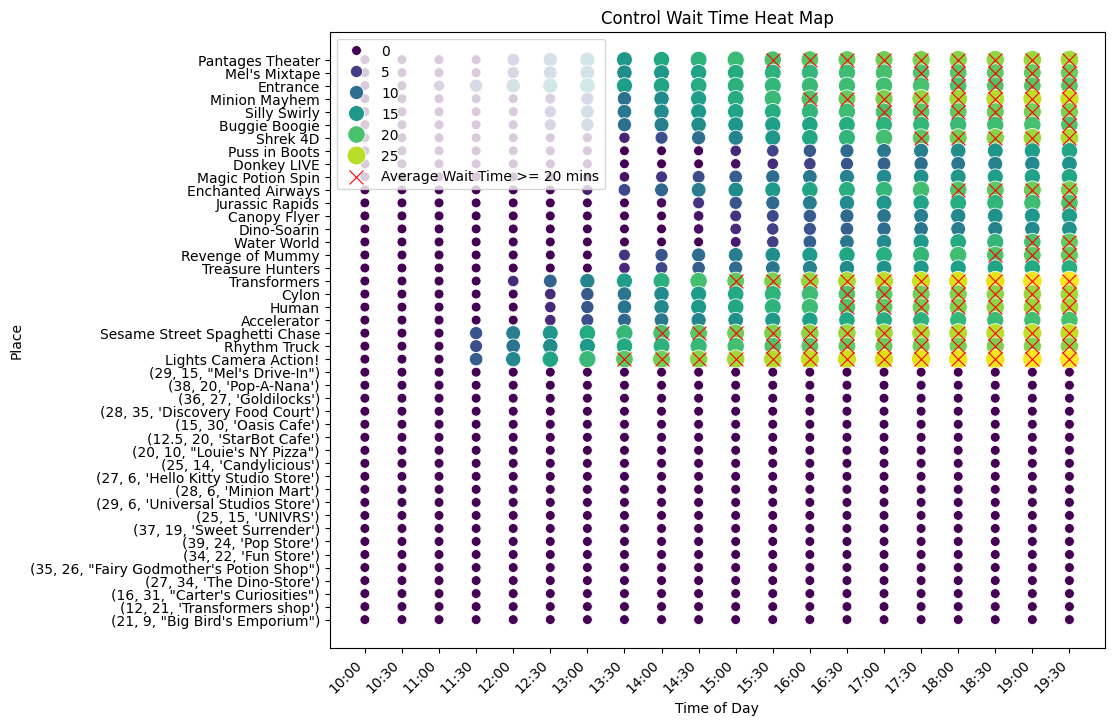

In [ ]:
# Load CSV (Time column formatted)
df_control = pd.read_csv('control_wait_times.csv')

# Convert 'timestamp' to datetime objects
df_control['timestamp'] = pd.to_datetime(df_control['timestamp'])

# Extract the time part of the timestamp and convert it to total minutes since midnight
df_control['time_minutes'] = df_control['timestamp'].dt.hour * 60 + df_control['timestamp'].dt.minute

# --- Create a new column with formatted time ---
df_control['time_formatted'] = pd.to_datetime(df_control['time_minutes'], unit='m').dt.strftime('%H:%M')

# Define a threshold for 'long' wait times (using 'average' wait time)
long_wait_time_threshold = 20  # minutes (adjust as needed)

# Filter data for long wait times
long_wait_times_df = df_control[df_control['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

# --- Control: Use time_formatted for x-axis ---
sns.scatterplot(data=df_control, x='time_formatted', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_formatted', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Control Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Change 1: +10% Capacity

In [ ]:
# Load CSV (Time column formatted)
df_c1 = pd.read_csv('formatted_change1_wait_times.csv')

# Convert 'timestamp' to datetime objects
df_c1['timestamp'] = pd.to_datetime(df_c1['timestamp'])

# Extract the time part of the timestamp and convert it to total minutes since midnight
df_c1['time_minutes'] = df_c1['timestamp'].dt.hour * 60 + df_c1['timestamp'].dt.minute

# --- Create a new column with formatted time ---
df_c1['time_formatted'] = pd.to_datetime(df_c1['time_minutes'], unit='m').dt.strftime('%H:%M')

# Define a threshold for 'long' wait times (using 'average' wait time)
long_wait_time_threshold = 20  # minutes (adjust as needed)

# Filter data for long wait times
long_wait_times_df = df_c1[df_c1['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

# --- Change 1: Use time_formatted for x-axis ---
sns.scatterplot(data=df_c1, x='time_formatted', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_formatted', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Change in Capacity Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

<ipython-input-40-033b619bc94f>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_c1['timestamp'] = pd.to_datetime(df_c1['timestamp'])


### Change 2: Reduced Buffer Time between each ride (7 Minute for control to 5 Minute)

<ipython-input-41-6ed862970b13>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_c2['timestamp'] = pd.to_datetime(df_c2['timestamp'])


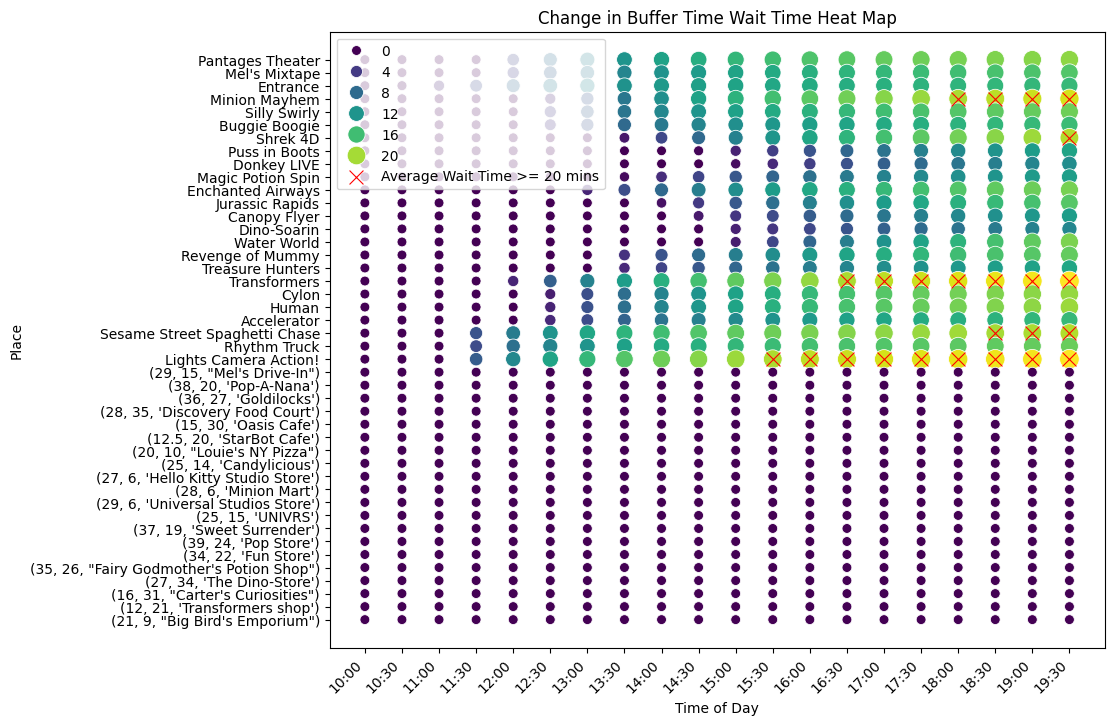

In [ ]:
# Load CSV (Time column formatted)
df_c2 = pd.read_csv('formatted_change2_wait_times.csv')

# Convert 'timestamp' to datetime objects
df_c2['timestamp'] = pd.to_datetime(df_c2['timestamp'])

# Extract the time part of the timestamp and convert it to total minutes since midnight
df_c2['time_minutes'] = df_c2['timestamp'].dt.hour * 60 + df_c2['timestamp'].dt.minute

# --- Create a new column with formatted time ---
df_c2['time_formatted'] = pd.to_datetime(df_c2['time_minutes'], unit='m').dt.strftime('%H:%M')

# Define a threshold for 'long' wait times (using 'average' wait time)
long_wait_time_threshold = 20  # minutes (adjust as needed)

# Filter data for long wait times
long_wait_times_df = df_c2[df_c2['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

# --- Change 2: Use time_formatted for x-axis ---
sns.scatterplot(data=df_c2, x='time_formatted', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_formatted', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Change in Buffer Time Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Change 3: Zone Rotation

<ipython-input-42-7430b1c6636a>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_c3['timestamp'] = pd.to_datetime(df_c3['timestamp'])


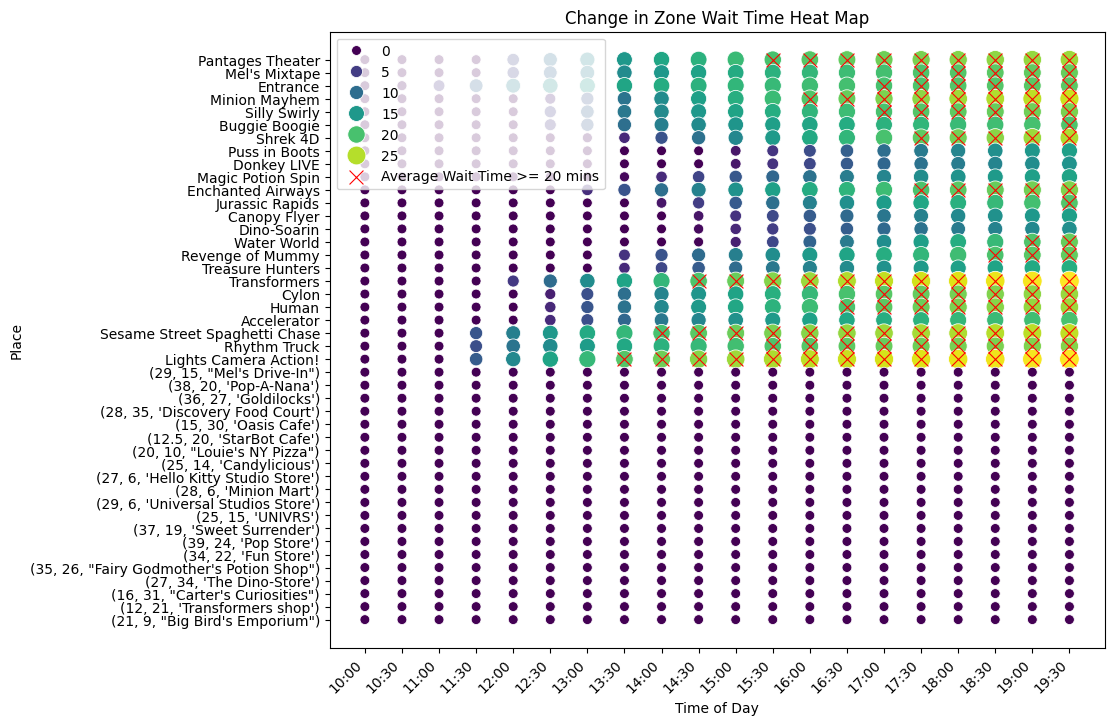

In [ ]:
# Load CSV (Time column formatted)
df_c3 = pd.read_csv('formatted_change3_wait_times.csv')

# Convert 'timestamp' to datetime objects
df_c3['timestamp'] = pd.to_datetime(df_c3['timestamp'])

# Extract the time part of the timestamp and convert it to total minutes since midnight
df_c3['time_minutes'] = df_c3['timestamp'].dt.hour * 60 + df_c3['timestamp'].dt.minute

# --- Create a new column with formatted time ---
df_c3['time_formatted'] = pd.to_datetime(df_c3['time_minutes'], unit='m').dt.strftime('%H:%M')

# Define a threshold for 'long' wait times (using 'average' wait time)
long_wait_time_threshold = 20  # minutes (adjust as needed)

# Filter data for long wait times
long_wait_times_df = df_c3[df_c3['average'] >= long_wait_time_threshold]

# Create a scatter plot highlighting long wait times
plt.figure(figsize=(10, 8))

# --- Change 3: Use time_formatted for x-axis ---
sns.scatterplot(data=df_c3, x='time_formatted', y='place', hue='average',
                palette='viridis', size='average', sizes=(50, 200))

# Highlight long wait times with a different marker
sns.scatterplot(data=long_wait_times_df, x='time_formatted', y='place', color='red',
                marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins')

plt.title('Change in Zone Wait Time Heat Map')
plt.xlabel('Time of Day')  # Update x-axis label
plt.ylabel('Place')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

### Comparison Plot for ALL: Control, C1, C2, C3

In [ ]:
# Create a figure with subplots for each scenario
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Function to create a scatter plot for a given dataframe and subplot axis
def plot_wait_times(df, ax, title):
  long_wait_time_threshold = 20
  long_wait_times_df = df[df['average'] >= long_wait_time_threshold]

  sns.scatterplot(data=df, x='time_formatted', y='place', hue='average',
                  palette='viridis', size='average', sizes=(50, 200), ax=ax)
  sns.scatterplot(data=long_wait_times_df, x='time_formatted', y='place', color='red',
                  marker='x', s=100, label=f'Average Wait Time >= {long_wait_time_threshold} mins', ax=ax)

  ax.set_title(title)
  ax.set_xlabel('Time of Day')
  ax.set_ylabel('Place')
  ax.legend()
  ax.tick_params(axis='x', rotation=45, labelsize=8)


# Plot each scenario in its respective subplot
plot_wait_times(df_control, axes[0, 0], 'Control Wait Time Heat Map')
plot_wait_times(df_c1, axes[0, 1], 'Change in Capacity Wait Time Heat Map')
plot_wait_times(df_c2, axes[1, 0], 'Change in Buffer Time Wait Time Heat Map')
plot_wait_times(df_c3, axes[1, 1], 'Change in Zone Wait Time Heat Map')


# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Function to calculate the rate of reduction in wait time for maximum wait time
def calculate_reduction_rate(df_base, df_change, place_name):

  base_wait_times = df_base[df_base['place'] == place_name]['maximum'].max()
  change_wait_times = df_change[df_change['place'] == place_name]['maximum'].max()

  if base_wait_times == 0:
    return float('inf')
  else:
    reduction_rate = ((change_wait_times - base_wait_times) / base_wait_times)
    return reduction_rate

# Create lists to store reduction rates for each change
c1_reduction_rates = []
c2_reduction_rates = []
c3_reduction_rates = []

# Iterate through each place and calculate the rate of reduction
places = df_control['place'].unique()
for place in places:
  # Calculate reduction rates for each change compared to the control
  c1_reduction_rate = calculate_reduction_rate(df_control, df_c1, place)
  c2_reduction_rate = calculate_reduction_rate(df_control, df_c2, place)
  c3_reduction_rate = calculate_reduction_rate(df_control, df_c3, place)

  c1_reduction_rates.append(c1_reduction_rate)
  c2_reduction_rates.append(c2_reduction_rate)
  c3_reduction_rates.append(c3_reduction_rate)

  # print(f"Place: {place}")
  # print(f"  Change 1 Reduction Rate: {c1_reduction_rate}")
  # print(f"  Change 2 Reduction Rate: {c2_reduction_rate}")
  # print(f"  Change 3 Reduction Rate: {c3_reduction_rate}")

# Create a bar chart to visualize the reduction rates
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(places))

plt.bar(index, c1_reduction_rates, width=bar_width, label='Change 1')
plt.bar([i + bar_width for i in index], c2_reduction_rates, width=bar_width, label='Change 2')
plt.bar([i + 2 * bar_width for i in index], c3_reduction_rates, width=bar_width, label='Change 3')

plt.xlabel('Place')
plt.ylabel('Reduction Rate')
plt.title('Reduction Rate of Maximum Wait Time')
plt.xticks([i + bar_width for i in index], places, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


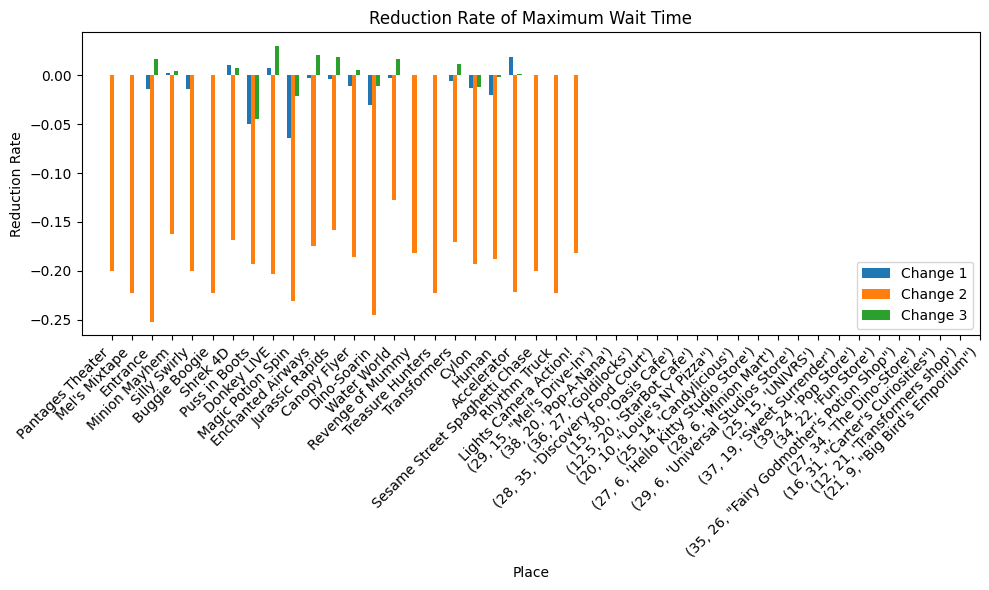

In [ ]:
def avg_calculate_reduction_rate(df_base, df_change, place_name):

  base_wait_times = df_base[df_base['place'] == place_name]['average'].max()
  change_wait_times = df_change[df_change['place'] == place_name]['average'].max()

  if base_wait_times == 0:
    return float('inf')
  else:
    reduction_rate = ((change_wait_times - base_wait_times) / base_wait_times)
    return reduction_rate

# Create lists to store reduction rates for each change
avg_c1_reduction_rates = []
avg_c2_reduction_rates = []
avg_c3_reduction_rates = []

# Iterate through each place and calculate the rate of reduction
places = df_control['place'].unique()
for place in places:
  # Calculate reduction rates for each change compared to the control
  c1_reduction_rate = avg_calculate_reduction_rate(df_control, df_c1, place)
  c2_reduction_rate = avg_calculate_reduction_rate(df_control, df_c2, place)
  c3_reduction_rate = avg_calculate_reduction_rate(df_control, df_c3, place)

  avg_c1_reduction_rates.append(c1_reduction_rate)
  avg_c2_reduction_rates.append(c2_reduction_rate)
  avg_c3_reduction_rates.append(c3_reduction_rate)

  # print(f"Place: {place}")
  # print(f"  Change 1 Reduction Rate: {c1_reduction_rate}")
  # print(f"  Change 2 Reduction Rate: {c2_reduction_rate}")
  # print(f"  Change 3 Reduction Rate: {c3_reduction_rate}")

# Create a bar chart to visualize the reduction rates
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(places))

plt.bar(index, avg_c1_reduction_rates, width=bar_width, label='Change 1')
plt.bar([i + bar_width for i in index], avg_c2_reduction_rates, width=bar_width, label='Change 2')
plt.bar([i + 2 * bar_width for i in index], avg_c3_reduction_rates, width=bar_width, label='Change 3')

plt.xlabel('Place')
plt.ylabel('Reduction Rate')
plt.title('Reduction Rate of Maximum Wait Time')
plt.xticks([i + bar_width for i in index], places, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Assess of Wait Time on Guest Satisfaction

Show that reduced wait times increases overall guest satisfaction:

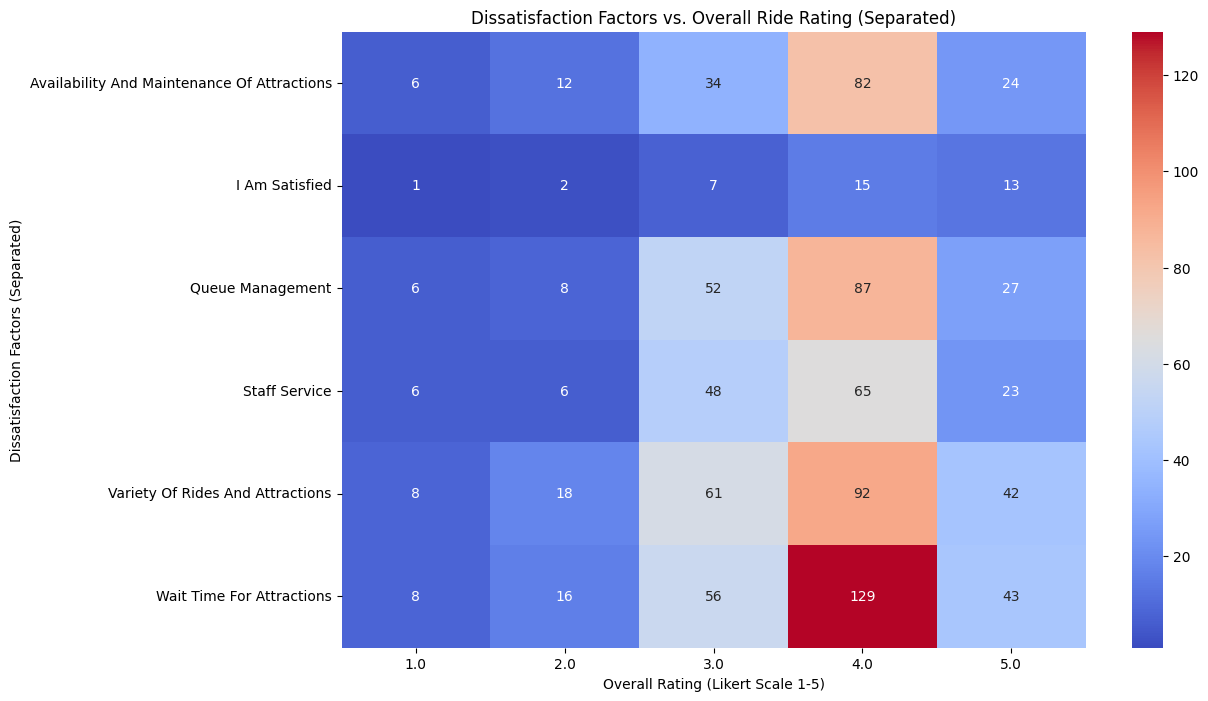

In [ ]:
### RIDES AND ATTRACTION:

rating_col = "Question 17.2: Give an overall rating for rides and attractions"  # Column storing Likert scale ratings (1-5)
dissatisfaction_col = "Question 18.2: For rides and attractions, which of the following services are you not satisfied with?"  # Column storing dissatisfaction reasons

# Create a list to store new DataFrame rows
new_rows = []

for index, row in survey_data.iterrows():
    dissatisfaction_reasons = str(row[dissatisfaction_col]).split(',')  # Split by comma
    for reason in dissatisfaction_reasons:
        reason = reason.strip()  # Remove leading/trailing spaces
        if reason:  # If reason is not empty
            new_row = row.copy()  # Create a copy of the original row
            new_row[dissatisfaction_col] = reason  # Assign the single reason
            new_rows.append(new_row)

# Create a new DataFrame with separated reasons
separated_data = pd.DataFrame(new_rows)

# Filter out unwanted reasons
filtered_data = separated_data[~separated_data[dissatisfaction_col].isin(["Not taking into account soft toy like me!", "nan"])]

# Group by rating and dissatisfaction reason and count occurrences
dissatisfaction_counts = filtered_data.groupby([rating_col, dissatisfaction_col]).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(dissatisfaction_counts.T, cmap="coolwarm", annot=True, fmt="d")
plt.xlabel("Overall Rating (Likert Scale 1-5)")
plt.ylabel("Dissatisfaction Factors (Separated)")
plt.title("Dissatisfaction Factors vs. Overall Ride Rating (Separated)")
plt.show()

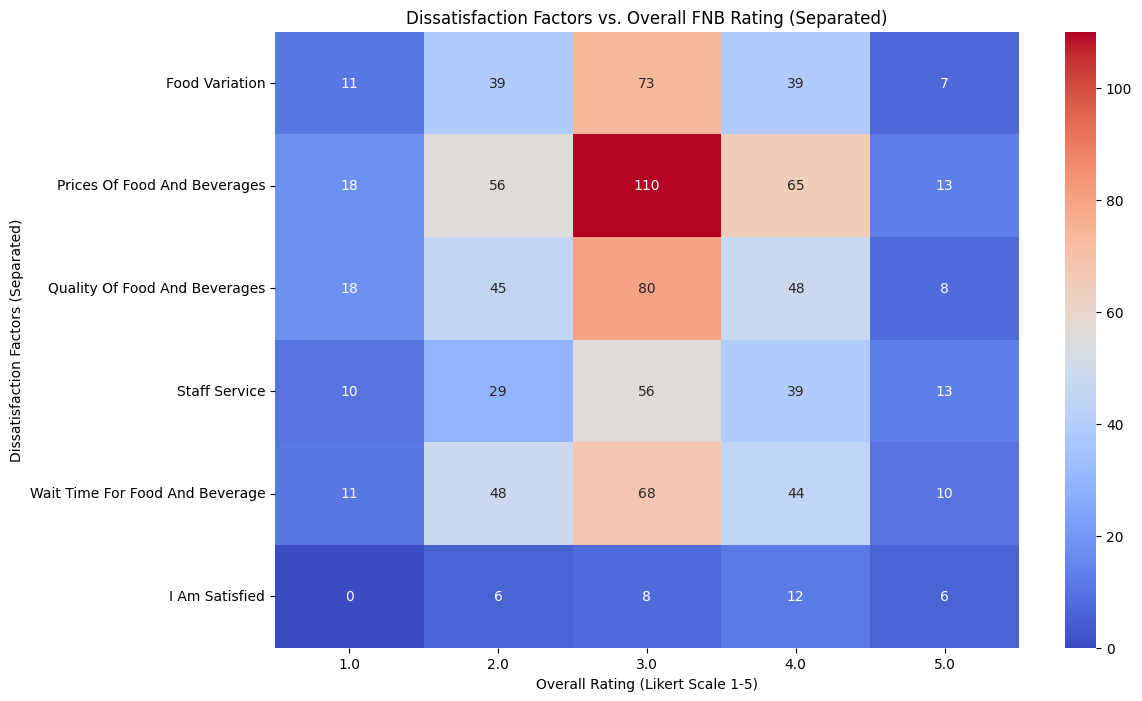

In [ ]:
### FNB

rating_col = "Question 17.4: Give an overall rating for food and beverage"  # Column storing Likert scale ratings (1-5)
dissatisfaction_col = "Question 18.4: For food and beverage, which of the following services are you not satisfied with?"  # Column storing dissatisfaction reasons

# Create a list to store new DataFrame rows
new_rows = []

for index, row in survey_data.iterrows():
    dissatisfaction_reasons = str(row[dissatisfaction_col]).split(',')  # Split by comma
    for reason in dissatisfaction_reasons:
        reason = reason.strip()  # Remove leading/trailing spaces
        if reason:  # If reason is not empty
            new_row = row.copy()  # Create a copy of the original row
            new_row[dissatisfaction_col] = reason  # Assign the single reason
            new_rows.append(new_row)

# Create a new DataFrame with separated reasons
separated_data = pd.DataFrame(new_rows)

# Filter out unwanted reasons
filtered_data = separated_data[~separated_data[dissatisfaction_col].isin(["nan"])]

# Group by rating and dissatisfaction reason and count occurrences
dissatisfaction_counts = filtered_data.groupby([rating_col, dissatisfaction_col]).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(dissatisfaction_counts.T, cmap="coolwarm", annot=True, fmt="d")
plt.xlabel("Overall Rating (Likert Scale 1-5)")
plt.ylabel("Dissatisfaction Factors (Separated)")
plt.title("Dissatisfaction Factors vs. Overall FNB Rating (Separated)")
plt.show()

Show that optimised layout might be able to shorten operation time for some spaces:

1. Theatres (Utility and Staffing)
2. Restaurants (Focus on Peak Hours)
3. Shops (Focus during Seasonal period when there are special events/merchandise or during the closing timings of the theme park)

# Keep for reference



### Simulation Visualization (Every 2 Hours for A Day)

In [ ]:
def plot_theme_park(model, step):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(5, 45)
    ax.set_ylim(5, 45)

    # Plot USS Zones
    legend_patches = []
    for zone, data in uss_zones.items():
        wedge = Wedge(PARK_CENTER, PARK_RADIUS, *data["angle_range"], color=data["color"], alpha=0.3)
        ax.add_patch(wedge)
        legend_patches.append(mpatches.Patch(color=data["color"], label=zone))  # Add zone to legend

    # Plot central water body
    ax.add_patch(Circle(PARK_CENTER, WATER_RADIUS, color="blue", alpha=0.1))
    # Add label for the water body at the center
    ax.text(PARK_CENTER[0], PARK_CENTER[1], "Water Body",
        fontsize=12, color="blue", fontweight="bold",
        ha="center", va="center",
        bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3', alpha=0.8))


    texts = []

    # Plot Attractions, Food Stalls, and Souvenir Shops
    categories = [
        (attractions, 'pink', "Attractions"),
        (food_stalls, 'orange', "Food Stalls"),
        (souvenir_shops, 'purple', "Souvenir Shops")
    ]

    for category, color, label in categories:
        for points in category.values():
            for x, y, name in points:
                ax.scatter(x, y, color=color, s=50, label=label if label not in [p.get_label() for p in legend_patches] else "")
                text = ax.text(x, y, name, fontsize=8, ha="center", va="center",
                               bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
                texts.append(text)

    # Plot Visitors
    for agent in model.schedule.agents:
        if isinstance(agent, Visitor):
            ax.scatter(*agent.pos, color='blue', s=10)  # Visitors

    # Automatically adjust text positions to prevent overlap
    adjust_text(texts, expand=(1.2, 1.5), arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    # Create a circular legend marker for Visitors and Staff
    visitor_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=4, label="Visitor")

    # Add Visitors to the legend
    legend_patches.extend([visitor_marker])
    legend_patches.extend([
        mlines.Line2D([], [], color='pink', marker='o', linestyle='None', markersize=8, label="Attractions"),
        mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=8, label="Food Stalls"),
        mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=8, label="Souvenir Shops"),
    ])
    ax.legend(handles=legend_patches, loc='upper right', fontsize=10)

    plt.show()


park = ThemePark()
for s in range(TIME_STEPS):
    park.step()
    plot_theme_park(park, s)

Time: 10:00 AM


KeyboardInterrupt: 

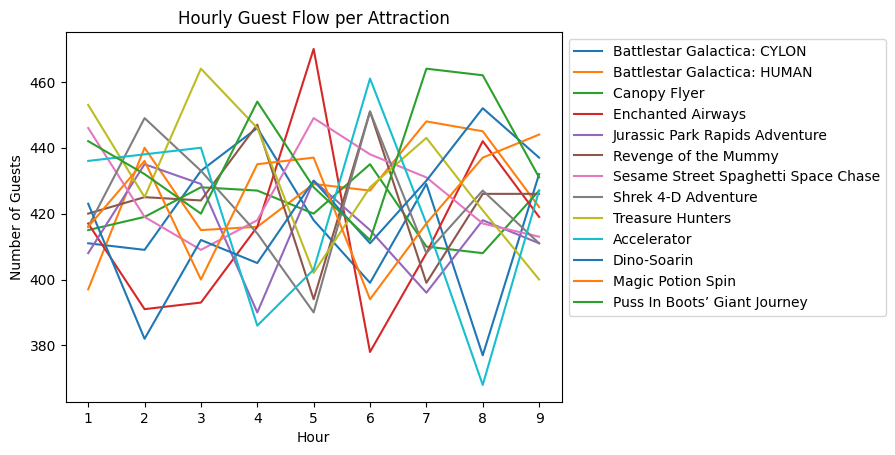

In [ ]:
# Assuming your data is in a pandas DataFrame named 'january_1_data'

# Extract relevant information for simulation
attraction_capacities = january_1_data['Total Hourly Capacity'].to_dict()
attraction_distances = january_1_data['Distance from Entrance (Meters)'].to_dict()
attraction_names = list(january_1_data['Attraction/Service'])

# Define simulation parameters
num_guests = 5500  # Total number of guests entering the park
simulation_hours = 9  # Number of hours to simulate

# Create a list to store the guest location at each hour
guest_locations = []

# Create a list to store hourly attraction visitor counts
# Use attraction names as keys, initialize with empty lists
hourly_attraction_visitors = {attraction_name: [] for attraction_name in attraction_names}


# Initialize guest locations at the entrance
for i in range(num_guests):
    guest_locations.append({'hour': 0, 'location': 'Entrance'})


# Function to simulate guest movement
def simulate_guest_movement(guest_location):
    # Choose next attraction based on proximity or random choice
    # (In this example, we randomly choose an attraction)

    # Use attraction_names instead of attraction_capacities.keys()
    next_attraction = np.random.choice(attraction_names)

    guest_location['hour'] += 1
    guest_location['location'] = next_attraction
    hourly_attraction_visitors[next_attraction].append(guest_location['hour'])



# Simulate guest movement over the simulation hours
for hour in range(simulation_hours):
    for guest_index in range(len(guest_locations)):
        if guest_locations[guest_index]['location'] != 'Exit':
            simulate_guest_movement(guest_locations[guest_index])


# Visualize the guest flow data

# Plot hourly visitor count for each attraction
for attraction in hourly_attraction_visitors:
    # Extract the number of visitors for each hour for a specific attraction
    visitor_count_per_hour = [hourly_attraction_visitors[attraction].count(hour) for hour in range(1, simulation_hours + 1)]

    plt.plot(list(range(1, simulation_hours + 1)), visitor_count_per_hour, label=attraction)


plt.xlabel('Hour')
plt.ylabel('Number of Guests')
plt.title('Hourly Guest Flow per Attraction')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Agent-Based Modeling to make changes to the following:

1.   Attraction/Service Capacity
2.   Attraction/Service Schedule
3.   Distance of Attraction/Service from Entrance


It is also understood that the above factors tested out are difficult to implement since the park layout and ride capacity are decided based on operation safety considerations.

Maybe to consider: Implementing Virtual Queue (Example: Wristband to vibrate when it is nearing their queue number instead of physical queues)



In [ ]:
# Simulation settings
SIM_TIME = 9 * 60  # 9 hours in minutes
TIME_INTERVAL = 60  # Track wait time every hour

class Attraction:
    def __init__(self, env, name, arrival_rate, hourly_capacity):
        self.env = env
        self.name = name
        self.arrival_rate = arrival_rate
        self.hourly_capacity = hourly_capacity
        self.ride = simpy.Resource(env, capacity=1)  # Single ride batch
        self.queue = []
        self.hourly_wait_times = {i: [] for i in range(int(SIM_TIME / 60) + 1)}  # Store wait times per hour

    def ride_process(self, guest_id, arrival_time):
        """Simulates a guest entering and waiting for the ride"""
        queue_entry_time = self.env.now
        self.queue.append(guest_id)  # Guest joins queue

        with self.ride.request() as request:
            yield request  # Wait until the ride is available

            # Calculate wait time
            wait_time = self.env.now - queue_entry_time
            hour = int(self.env.now // 60)

            # Check if 'hour' is a valid key in hourly_wait_times
            # If not, create a new list for that hour
            if hour not in self.hourly_wait_times:
                self.hourly_wait_times[hour] = []

            self.hourly_wait_times[hour].append(wait_time)  # Store for later analysis

            # Simulate ride time
            ride_duration = 60 / (self.hourly_capacity / 60)  # Avg ride cycle time
            yield self.env.timeout(ride_duration)
            self.queue.remove(guest_id)  # Guest leaves queue

    def get_hourly_avg_wait_time(self):
        """Calculate average wait time per hour"""
        return {hour: (sum(times) / len(times) if times else 0) for hour, times in self.hourly_wait_times.items()}

    def get_hourly_wait_times(self):
        """Returns a dictionary of hourly wait times for this attraction."""
        return self.hourly_wait_times

def guest_arrival(env, attraction):
    """Simulates dynamic guest arrivals"""
    guest_id = 0
    while True:
        # Adjust arrival rate per hour
        hour = int(env.now // 60)
        dynamic_arrival_rate = max(1, attraction.arrival_rate + random.randint(-2, 2))
        yield env.timeout(random.expovariate(dynamic_arrival_rate))

        guest_id += 1
        env.process(attraction.ride_process(guest_id, env.now))

# Create simulation environment
env = simpy.Environment()
attractions = []
all_wait_times = {}

# Iterate through unique attractions in combined_data
for attraction_name in combined_data['Attraction/Service'].unique():
    # Get attraction data from combined_data
    attraction_data = combined_data[combined_data['Attraction/Service'] == attraction_name]
    hourly_capacity = attraction_data['Total Hourly Capacity'].iloc[0]

    # Create an Attraction object
    attraction = Attraction(env, attraction_name, 0, hourly_capacity)
    attractions.append(attraction)

    # Simulate guest arrivals based on wait_times_data within combined_data
    def guest_arrival_from_data(env, attraction, attraction_data):
        """Simulates guest arrivals based on combined_data"""
        guest_id = 0
        for _, row in attraction_data.iterrows():  # Iterate through each hour's data
            arrival_time = row['DateTime'].hour * 60  # Convert hour to minutes
            arrival_rate = row['Visitor Count']

            # Check if arrival_rate is valid before conversion
            if pd.notna(arrival_rate):  # Check if not NaN
                arrival_rate = int(arrival_rate)  # Convert to integer only if not NaN
            else:
                arrival_rate = 0  # Or handle NaN as needed (e.g., set to 0)


            # Calculate delay, ensuring it's not negative
            delay = max(0, arrival_time - env.now)  # Use max(0, ...) to avoid negative delays

            yield env.timeout(delay)  # Wait until the next arrival time

            # Simulate arrivals for the current hour
            for _ in range(int(arrival_rate)):
                guest_id += 1
                env.process(attraction.ride_process(guest_id, env.now))

    # Start the guest arrival process for this attraction
    env.process(guest_arrival_from_data(env, attraction, attraction_data))

# Run simulation
env.run(until=SIM_TIME)


# Print hourly wait times for each attraction
for attraction in attractions:
    print(f"\n{attraction.name} Hourly Wait Times:")
    hourly_waits = attraction.get_hourly_wait_times()
    all_wait_times[attraction.name] = hourly_waits #store into dictionary
    for hour, wait_times in hourly_waits.items(): # Change wait_time to wait_times
        avg_wait_time = sum(wait_times) / len(wait_times) if wait_times else 0 # Calculate average wait time
        print(f"Hour {hour}: {round(avg_wait_time, 2)} minutes") # Round the average


Battlestar Galactica: CYLON Hourly Wait Times:
Hour 0: 0 minutes
Hour 1: 0 minutes
Hour 2: 0 minutes
Hour 3: 0 minutes
Hour 4: 0 minutes
Hour 5: 0 minutes
Hour 6: 0 minutes
Hour 7: 0 minutes
Hour 8: 0 minutes
Hour 9: 0 minutes

Battlestar Galactica: HUMAN Hourly Wait Times:
Hour 0: 0 minutes
Hour 1: 0 minutes
Hour 2: 0 minutes
Hour 3: 0 minutes
Hour 4: 0 minutes
Hour 5: 0 minutes
Hour 6: 0 minutes
Hour 7: 0 minutes
Hour 8: 0 minutes
Hour 9: 0 minutes

Canopy Flyer Hourly Wait Times:
Hour 0: 0 minutes
Hour 1: 0 minutes
Hour 2: 0 minutes
Hour 3: 0 minutes
Hour 4: 0 minutes
Hour 5: 0 minutes
Hour 6: 0 minutes
Hour 7: 0 minutes
Hour 8: 0 minutes
Hour 9: 0 minutes

Enchanted Airways Hourly Wait Times:
Hour 0: 0 minutes
Hour 1: 0 minutes
Hour 2: 0 minutes
Hour 3: 0 minutes
Hour 4: 0 minutes
Hour 5: 0 minutes
Hour 6: 0 minutes
Hour 7: 0 minutes
Hour 8: 0 minutes
Hour 9: 0 minutes

Jurassic Park Rapids Adventure Hourly Wait Times:
Hour 0: 0 minutes
Hour 1: 0 minutes
Hour 2: 0 minutes
Hour 3: 

In [ ]:
class GuestAgent(Agent):
    """An agent representing a guest in the park."""

    def __init__(self, unique_id, model, arrival_time, attraction_name):
        super().__init__(unique_id, model)
        self.arrival_time = arrival_time
        self.attraction_name = attraction_name
        self.wait_time = 0
        self.is_done = False

    def step(self):
        """Guest actions in the simulation"""
        if not self.is_done:
            # Find the corresponding attraction object
            attraction = next((a for a in self.model.attractions if a.name == self.attraction_name), None)

            if attraction:
                # Simulate entering the queue
                queue_entry_time = self.model.schedule.time
                attraction.queue.append(self)

                # Simulate waiting in queue (can be improved)
                if attraction.ride.count == attraction.ride.capacity:
                    self.wait_time += 1  # Placeholder for wait calculation
                else:
                    # Simulate riding process
                    self.wait_time = self.model.schedule.time - self.arrival_time
                    attraction.queue.remove(self)
                    ride_duration = 60 / (attraction.hourly_capacity / 60)
                    self.model.schedule.time += ride_duration
                    self.is_done = True

class GuestFlowModel(Model):
    """Mesa model for simulating guest flow."""

    def __init__(self, combined_data):
        self.schedule = RandomActivation(self)
        self.combined_data = combined_data
        self.attractions = []
        self.running = True

        # Initialize attractions from combined data
        for attraction_name in combined_data['Attraction/Service'].unique():
            attraction_data = combined_data[combined_data['Attraction/Service'] == attraction_name]
            hourly_capacity = attraction_data['Total Hourly Capacity'].iloc[0]
            attraction = Attraction(self, attraction_name, 0, hourly_capacity)
            self.attractions.append(attraction)

        # Set up data collector
        self.datacollector = DataCollector(
            model_reporters={"Average Wait Time": lambda m: self.calculate_average_wait_time()}
        )


        # Initialize guest agents
        guest_id = 0
        for _, row in self.combined_data.iterrows():
            arrival_time = row['DateTime'].hour * 60  # Convert hour to minutes
            attraction_name = row['Attraction/Service']
            for _ in range(int(row['Visitor Count'])):
                guest_id += 1
                guest = GuestAgent(guest_id, self, arrival_time, attraction_name)
                self.schedule.add(guest)

    def calculate_average_wait_time(self):
        """Calculates average wait time for all guests"""
        total_wait_time = sum([guest.wait_time for guest in self.schedule.agents if guest.is_done])
        num_guests_done = sum([1 for guest in self.schedule.agents if guest.is_done])
        if num_guests_done > 0:
            return total_wait_time / num_guests_done
        return 0  # Avoid division by zero if no guests are done

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()
        self.datacollector.collect(self)

# Example Usage:
model = GuestFlowModel(january_1_data)

# Run the simulation for a set number of steps (e.g., 9 hours * 60 minutes)
for i in range(9 * 60):
    model.step()

# Analyze results
results = model.datacollector.get_model_vars_dataframe()
results


Average Wait Time
0        662962.309969
1        662962.309969
2        662962.309969
3        662962.309969
4        662962.309969
..                 ...
535      662962.309969
536      662962.309969
537      662962.309969
538      662962.309969
539      662962.309969

[540 rows x 1 columns]

IDK WHAT IM DOING

In [ ]:
# Function to simulate a change in attraction capacity
def change_attraction_capacity(attraction, new_capacity):
    attraction.hourly_capacity = new_capacity

# Example: Increase capacity of Transformers: The Ride by 20%
transformers_attraction = next((attr for attr in attractions if attr.name == "Transformers: The Ride"), None)
if transformers_attraction:
    original_capacity = transformers_attraction.hourly_capacity
    new_capacity = int(original_capacity * 1.2)
    change_attraction_capacity(transformers_attraction, new_capacity)
    print(f"Transformers: The Ride capacity increased from {original_capacity} to {new_capacity}")


# Run simulation again after capacity change
env.run(until=SIM_TIME)

# ... (Rest of your code for printing and analysis) ...


# Function to simulate a change in attraction schedule (e.g., operating hours)
def change_attraction_schedule(attraction, new_start_hour, new_end_hour):
  # Implement logic to modify the guest_arrival_from_data process
  # to only generate guests during the new operating hours
  pass

# Example: Shorten operating hours for Jurassic Park Rapids Adventure
#jurassic_park_attraction = ...
#change_attraction_schedule(jurassic_park_attraction, 10, 17) # 10am to 5pm


# Function to simulate a change in attraction distance from the entrance
def change_attraction_distance(attraction, new_distance):
    # You can modify the guest's travel time to the attraction
    # based on this new distance in the guest_arrival_from_data process
    pass


# Example: Reduce distance for Sesame Street Spaghetti Space Chase
#sesame_street_attraction = ...
#change_attraction_distance(sesame_street_attraction, 200) # Reduce distance

# ... (Continue with your analysis of the simulation results) ...


             Date  Date/Time                                           Ride  \
0      2024-01-01         10                                    Accelerator   
1      2024-01-01         10                    Battlestar Galactica: CYLON   
2      2024-01-01         10                    Battlestar Galactica: HUMAN   
3      2024-01-01         10                                   Canopy Flyer   
4      2024-01-01         10                                    Dino-Soarin   
...           ...        ...                                            ...   
47957  2025-02-28         19                           Revenge of the Mummy   
47958  2025-02-28         19            Sesame Street Spaghetti Space Chase   
47959  2025-02-28         19                            Shrek 4-D Adventure   
47960  2025-02-28         19  TRANSFORMERS The Ride: The Ultimate 3D Battle   
47961  2025-02-28         19                               Treasure Hunters   

                 Zone  Wait Time  Visitor Count  Ne

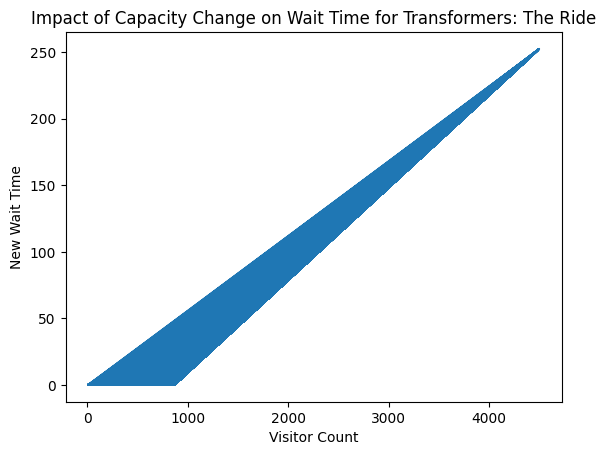

In [ ]:
# Function to simulate wait time based on attraction capacity and visitor count
def simulate_wait_time(capacity, visitor_count):
  """Simulates wait time based on attraction capacity and visitor count.

  Args:
    capacity: The attraction's capacity (number of visitors per hour).
    visitor_count: The number of visitors trying to use the attraction.

  Returns:
    The estimated wait time in minutes.
  """
  if visitor_count <= capacity:
    return 0  # No wait time if capacity is sufficient
  else:
    # Simple wait time estimation: queue length divided by service rate
    wait_time = (visitor_count - capacity) / (capacity / 60)  # Assuming a service rate of capacity/60 visitors per minute
    return wait_time


# Example: Adjusting capacity for 'Transformers: The Ride' based on visitor count
attraction_name = 'Transformers: The Ride'
attraction_data = df_uss[df_uss['Attraction/Service'] == attraction_name]
original_capacity = attraction_data['Total Hourly Capacity'].iloc[0]

# Loop through each hour's visitor count and calculate new wait times with adjusted capacity
for index, row in wait_times_data.iterrows():
  visitor_count = row['Visitor Count']  # Replace 'Visitor Count' with the actual column name

  # Adjust capacity based on visitor count. This is a simple example, you can use more complex logic here.
  new_capacity = original_capacity * 1.2 if visitor_count > original_capacity else original_capacity

  # Simulate wait time with the new capacity
  new_wait_time = simulate_wait_time(new_capacity, visitor_count)

  #print(f"Hour: {index}, Original Capacity: {original_capacity}, Visitor Count: {visitor_count}, New Capacity: {new_capacity}, New Wait Time: {new_wait_time}")

  # Add new wait time to wait_times_data for analysis. Add the column "New Wait Time" to wait_times_data
  wait_times_data.loc[index, 'New Wait Time'] = new_wait_time

print(wait_times_data)

# Visualize or analyze the results
plt.plot(wait_times_data['Visitor Count'], wait_times_data['New Wait Time'])
plt.xlabel("Visitor Count")
plt.ylabel("New Wait Time")
plt.title(f"Impact of Capacity Change on Wait Time for {attraction_name}")
plt.show()



Assess Impact on Wait time, Satisfaction and Revenue:

1. Consider correlation analysis between factors affecting guest satisfaction (determine importance of wait time in affecting guest experience)

2. Understand the distribution of Attraction/Service, may be able to have staggered opening/closing to reduce operational cost, increasing revenue.

Show that reduced wait times increases overall guest satisfaction:

In [ ]:
### can compare the matrix with synthetic and without synthetic data to determine which has more meaning to it
## Answers impact on guest satisfaction

# Calculate the correlation matrix
correlation_matrix = survey_data[['Ride_Rating', 'Food_Rating', 'Overall_Satisfaction']].corr() # to include actual data once cleaned

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Ratings and Overall Satisfaction')
plt.show()


#### OR: To evaluate the p-value and correlations of features
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, ax=ax)

# corr, p_value = spearmanr(data columns )
#     print(f"Spearman correlation between {feature} and Overall_Satisfaction : {corr:.5g}, p-value: {p_value:.5g}")




Show that optimised layout might be able to shorten operation time for some spaces:

1. Theatres (Utility and Staffing)
2. Restaurants (Focus on Peak Hours)
3. Shops (Focus during Seasonal period when there are special events/merchandise or during the closing timings of the theme park)

In [ ]:
### USS Attraction Data

# Creating the DataFrame
uss_data = {
    "Attraction/Service": [
        "Battlestar Galactica: CYLON", "Battlestar Galactica: HUMAN", "Canopy Flyer",
        "Enchanted Airways", "Jurassic Park Rapids Adventure", "Lights, Camera, Action!",
        "Revenge of the Mummy", "Sesame Street Spaghetti Space Chase", "Shrek 4-D Adventure",
        "Transformers: The Ride", "Treasure Hunters", "Accelerator", "Dino-Soarin",
        "Magic Potion Spin", "Puss In Boots’ Giant Journey",
        "Mel's Drive-In", "Universal Studios Store", "KT's Grill", "StarBot Café",
        "Oasis Spice Café", "Fossil Fuels", "Goldilocks Fried Chicken", "Gloria's Snack Shack"
    ],
    "Type": [
        "Ride", "Ride", "Ride", "Ride", "Ride", "Show",
        "Ride", "Ride", "Show", "Ride", "Ride", "Ride", "Ride",
        "Ride", "Ride",
        "Restaurant", "Shop", "Restaurant", "Restaurant",
        "Restaurant", "Restaurant", "Restaurant", "Restaurant"
    ],
    "Capacity (Guests per Interval)": [
        16, 16, 32, 20, 72, 300,
        24, 20, 500, 60, 16, 32, 24,
        16, 40,
        200, 100, 150, 100,
        80, 50, 120, 60
    ],
    "Interval (Minutes per Cycle)": [
        3, 3, 3, 2, 7, 20,
        3, 5, 20, 5, 7, 3, 2,
        2, 5,
        None, None, None, None,
        None, None, None, None
    ],
    "Distance from Entrance (Meters)": [
        400, 400, 750, 950, 800, 200,
        600, 250, 900, 450, 650, 300, 700,
        350, 500,
        100, 80, 220, 420,
        620, 780, 920, 1020
    ],
    "Total Hourly Capacity": [
        640, 640, 640, 600, 617, 900,
        480, 240, 1500, 720, 137, 640, 720,
        480, 480,
        None, None, None, None,
        None, None, None, None
    ]
}


# Converting to DataFrame
df_uss = pd.DataFrame(uss_data)

# Fill intervals for Restaurants and Shops (Assume restaurant to be 60 minutes interval and Shops to be 20 minutes interval)
df_uss.loc[df_uss['Type'] == 'Restaurant', 'Interval (Minutes per Cycle)'] = 60
df_uss.loc[df_uss['Type'] == 'Shop', 'Interval (Minutes per Cycle)'] = 20

# Account that Rides take another +10min for safety check and for passengers to get on and off before starting another session
df_uss.loc[df_uss['Type'] == 'Ride', 'Interval (Minutes per Cycle)'] += 10

# Recalculate Total Hourly Capacity
df_uss['Total Hourly Capacity'] = (60 / df_uss['Interval (Minutes per Cycle)']) * df_uss['Capacity (Guests per Interval)']

# Display DataFrame
df_uss


Attraction/Service        Type  \
0           Battlestar Galactica: CYLON        Ride   
1           Battlestar Galactica: HUMAN        Ride   
2                          Canopy Flyer        Ride   
3                     Enchanted Airways        Ride   
4        Jurassic Park Rapids Adventure        Ride   
5               Lights, Camera, Action!        Show   
6                  Revenge of the Mummy        Ride   
7   Sesame Street Spaghetti Space Chase        Ride   
8                   Shrek 4-D Adventure        Show   
9                Transformers: The Ride        Ride   
10                     Treasure Hunters        Ride   
11                          Accelerator        Ride   
12                          Dino-Soarin        Ride   
13                    Magic Potion Spin        Ride   
14         Puss In Boots’ Giant Journey        Ride   
15                       Mel's Drive-In  Restaurant   
16              Universal Studios Store        Shop   
17                           KT's Grill  Restaurant   
18                         StarBot Café  Restaurant   
19                     Oasis Spice Café  Restaurant   
20                         Fossil Fuels  Restaurant   
21             Goldilocks Fried Chicken  Restaurant   
22                 Gloria's Snack Shack  Restaurant   

    Capacity (Guests per Interval)  Interval (Minutes per Cycle)  \
0                               16                          13.0   
1                               16                          13.0   
2                               32                          13.0   
3                               20                          12.0   
4                               72                          17.0   
5                              300                          20.0   
6                               24                          13.0   
7                               20                          15.0   
8                              500                          20.0   
9                               60                          15.0   
10                              16                          17.0   
11                              32                          13.0   
12                              24                          12.0   
13                              16                          12.0   
14                              40                          15.0   
15                             200                          60.0   
16                             100                          20.0   
17                             150                          60.0   
18                             100                          60.0   
19                              80                          60.0   
20                              50                          60.0   
21                             120                          60.0   
22                              60                          60.0   

    Distance from Entrance (Meters)  Total Hourly Capacity  
0                               400              73.846154  
1                               400              73.846154  
2                               750             147.692308  
3                               950             100.000000  
4                               800             254.117647  
5                               200             900.000000  
6                               600             110.769231  
7                               250              80.000000  
8                               900            1500.000000  
9                               450             240.000000  
10                              650              56.470588  
11                              300             147.692308  
12                              700             120.000000  
13                              350              80.000000  
14                              500             160.000000  
15                              100             200.000000  
16                            

In [ ]:
### Load Dataset

# Wait time and Visitor Count Dataset (Per Hour everyday in 2024)
wait_times_data = pd.read_csv("waittime_cleandata.csv")

# wait_times_data.head()

wait_times_data['Date'] = pd.to_datetime(wait_times_data['Date'])
wait_times_data['DateTime'] = wait_times_data['Date'] + pd.to_timedelta(wait_times_data['Date/Time'], unit = 'h')

wait_times_data = wait_times_data.drop(columns = ['Date', 'Date/Time'])

wait_times_data.head()

# Survey Data

# Demand Prediction Data